In [1]:
import tushare as ts
import pandas as pd
import talib
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # 分割子图

#### 获取股票交易数据接口GetStockDatApi。(股票代码，起始日期)

- :param data: code 股票代码
- :param data: start 起始日期
- :param data: end 终止日期
- :return data: df_recon 规整化后的DataFrame格式股票数据

In [2]:
def GetStockDataApi(stockCode,start,end):
    token = ""  # your token
    pro = ts.pro_api(token)  #初始化pro接口
    # 获取
    stockdata = pro.daily(ts_code=stockCode,start_date=start,end_date=end)
    # 索引
    stockdata.trade_date = pd.to_datetime(stockdata.trade_date)
    stockdata['trade_date'] = stockdata['trade_date'].dt.date
    stockdata.set_index('trade_date',drop=True,inplace=True)
    stockdata.sort_index(inplace=True)
    # 删除无用列
    stockdata = stockdata.drop(columns='ts_code')
    return stockdata

#### 择时策略信号生成接口，此处为计算N日突破信号CalNdaysSignal。默认N1=15,N2=5

- :param data: stockdata 个股行情数据
- :param data: N1 策略参数，默认为15
- :param data: N2 策略参数，默认为5
- :return data: 添加交易信号的DataFrame格式股票数据

In [3]:
def NdaysSignal(stockdata,N1=15,N2=5):
    stockdata['N1_High'] = stockdata.high.rolling(window=N1).max()#计算最近N1个交易日最高价
    expan_max = stockdata.close.expanding().max()
    stockdata['N1_High'].fillna(value=expan_max,inplace=True)#目前出现过的最大值填充前N1个nan
    
    stockdata['N2_Low'] = stockdata.low.rolling(window=N2).min()#计算最近N2个交易日最低价
    expan_min = stockdata.close.expanding().min()
    stockdata['N2_Low'].fillna(value=expan_min,inplace=True)#目前出现过的最小值填充前N2个nan

    #收盘价超过N1最高价 买入股票持有
    buy_index = stockdata[stockdata.close > stockdata.N1_High.shift(1)].index
    stockdata.loc[buy_index,'signal'] = 1
    #收盘价超过N2最低价 卖出股票持有
    sell_index = stockdata[stockdata.close < stockdata.N2_Low.shift(1)].index
    stockdata.loc[sell_index,'signal'] = 0
    
    stockdata['signal'].fillna(method = 'ffill',inplace = True)
    stockdata['signal'] = stockdata.signal.shift(1)
    stockdata['signal'].fillna(method = 'bfill',inplace = True)
    
    return stockdata



#### 择时策略融入风险管理因子生成交易信号接口CalNdaysStopSignal()
- :param data: stockdata 个股行情数据
- :param data: N1 策略参数，默认为15
- :param data: N2 策略参数，默认为5
- :param data: n_loss 止损策略参数，默认为0.8
- :param data: n_win 止盈策略参数，默认为2
- :return data: 规整化后 添加交易信号的DataFrame格式股票数据

In [4]:
def NdaysStopSignal(stockdata,N1=15,N2=5,n_loss=0.8,n_win=2):
    stockdata['N1_High'] = stockdata.high.rolling(window=N1).max()#计算最近N1个交易日最高价
    stockdata['N1_High'] = stockdata.N1_High.shift(1)
    expan_max = stockdata.close.expanding().max()
    stockdata['N1_High'].fillna(value=expan_max,inplace=True)#目前出现过的最大值填充前N1个nan

    stockdata['N2_Low'] = stockdata.low.rolling(window=N2).min()#计算最近N2个交易日最低价
    stockdata['N2_Low'] = stockdata.N2_Low.shift(1)
    expan_min = stockdata.close.expanding().min()
    stockdata['N2_Low'].fillna(value=expan_min,inplace=True)#目前出现过的最小值填充前N2个nan

    stockdata['atr14'] = talib.ATR(stockdata.high.values, stockdata.low.values, stockdata.close.values, timeperiod=14)  # 计算ATR14
    buy_price = 0
    for kl_index, today in stockdata.iterrows():
        if today.close > today.N1_High:
            buy_price = today.close
            stockdata.loc[kl_index, 'signal'] = 1

        elif (buy_price != 0) and (buy_price > today.close) and ((buy_price - today.close) > n_loss * today.atr14):
            stockdata.loc[kl_index, 'signal'] = 0
            buy_price = 0

        elif (buy_price != 0) and (buy_price < today.close) and ((today.close - buy_price) > n_win * today.atr14):
            stockdata.loc[kl_index, 'signal'] = 0
            buy_price = 0
            
        elif today.close < today.N2_Low:
            stockdata.loc[kl_index, 'signal'] = 0
            buy_price = 0
            
        else:
            pass

    stockdata['signal'].fillna(method = 'ffill',inplace = True)
    stockdata['signal'] = stockdata.signal.shift(1)
    stockdata['signal'].fillna(method = 'bfill',inplace = True)

    return stockdata

#### 输出策略回测报告接口SimpleBackTest_info

- :param data: stockdata 股票数据及交易信号
- :param data: code_name 股票名称
- :param data: cash_hold 回测资金
- :return data: 添加回测结果的DataFrame格式股票数据

In [5]:
def SimpleBackTest_info(stockdata,strategy_name,stock_name,cash_hold):
    # 解决中文问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    #初始化变量
    cash_start = cash_hold
    posit_num = 0 #持股数目
    market_total = 0 #持股市值
    skip_days = 0 #持股/持币状态
    track_times = 0
    track_win_times = 0
    #创建图表
    fig = plt.figure(figsize=(10, 8), dpi=100, facecolor="white")#创建fig对象
    gs = gridspec.GridSpec(3, 1, left=0.05, bottom=0.1, right=0.96, top=0.96, wspace=None, hspace=0.05, height_ratios=[4,2,2])
    graph_trade = fig.add_subplot(gs[0,:])
    graph_total = fig.add_subplot(gs[1,:])
    graph_profit = fig.add_subplot(gs[2,:])
    
    #获取股票交易数据
    df_stockload = stockdata
    for kl_index, today in df_stockload.iterrows():
        # 买入/卖出执行代码
        if today.signal == 1 and skip_days == 0:  # 买入
            start = df_stockload.index.get_loc(kl_index)
            skip_days = -1
            posit_num = int(str(int(cash_hold / today.close))[:-2] + '00') #资金转化为股票
            cash_hold = cash_hold - int(posit_num * today.close)
            graph_trade.annotate(f'{kl_index}以{today.close}买入',xy=(kl_index,df_stockload.close.asof(kl_index)),xytext=(kl_index, df_stockload.close.asof(kl_index)+2),arrowprops=dict(facecolor='r',shrink=0.1),horizontalalignment='left',verticalalignment='top')
            print(f"在 {kl_index} 以 {today.close} 价格--买入{stock_name} {posit_num}股")
            print(f"剩余资金:{cash_hold}")
        elif today.signal == 0 and skip_days == -1:  # 卖出 避免未买先卖
            end = df_stockload.index.get_loc(kl_index)
            skip_days = 0
            print(f"在 {kl_index} 以 {today.close} 价格--卖出{stock_name} {posit_num}股")
            track_times += 1
            cash_hold = cash_hold + int(posit_num * today.close) #股票转化为资金
            print(f"剩余资金:{cash_hold}")
            market_total = 0
            

            if df_stockload.close[end] < df_stockload.close[start]:  # 赔钱显示绿色
                graph_trade.fill_between(df_stockload.index[start:end], 0, df_stockload.close[start:end], color='green', alpha=0.38)
            else:  # 赚钱显示红色
                track_win_times += 1
                graph_trade.fill_between(df_stockload.index[start:end], 0, df_stockload.close[start:end], color='red', alpha=0.38)
            graph_trade.annotate(f'{kl_index}以{today.close}卖出',xy=(kl_index,df_stockload.close.asof(kl_index)),xytext=(kl_index+datetime.timedelta(days=5), df_stockload.close.asof(kl_index)+2),arrowprops=dict(facecolor='g',shrink=0.1),horizontalalignment='left',verticalalignment='top')

        if skip_days == -1: #持股
            market_total = int(posit_num * today.close)
            df_stockload.loc[kl_index,'total'] = market_total
        else: #空仓
            df_stockload.loc[kl_index,'total'] = cash_hold
        #计算基准收益/趋势突破策略收益
    df_stockload['benchmark_profit'] = np.log(df_stockload.close/df_stockload.close.shift(1))
    df_stockload['trend_profit'] = df_stockload.signal*df_stockload.benchmark_profit
    df_stockload[['benchmark_profit','trend_profit']].cumsum().plot(grid=True,ax=graph_profit)

    #计算收盘价曲线当前的滚动最高值
    df_stockload['max_close'] = df_stockload['close'].expanding().max()
    df_stockload[['max_close','close']].plot(grid=True,ax=graph_trade)

    #计算资金曲线当前的滚动最高值
    df_stockload['max_total'] = df_stockload['total'].expanding().max()
    df_stockload[['max_total','total']].plot(grid=True,ax=graph_total)

    #计算资金曲线在滚动最高值之后所回撤的百分比
    df_stockload['per_total'] = df_stockload['total'] / df_stockload['max_total']
    min_point_total = df_stockload.sort_values(by=['per_total']).iloc[[0], df_stockload.columns.get_loc('per_total')]
    max_point_total = df_stockload[df_stockload.index <= min_point_total.index[0]].sort_values \
        (by=['total'], ascending=False).iloc[[0], df_stockload.columns.get_loc('total')]

    #标注滚动最大点及最大回撤点
    graph_total.annotate('滚动最大点',
                         xy=(max_point_total.index[0], df_stockload.total.asof(max_point_total.index[0])),
                         xytext=(max_point_total.index[0], df_stockload.total.asof(max_point_total.index[0]) + 4),
                         arrowprops=dict(facecolor='yellow', shrink=0.1), horizontalalignment='left',
                         verticalalignment='top')
    graph_total.annotate('最大回撤点',
                         xy=(min_point_total.index[0], df_stockload.total.asof(min_point_total.index[0])),
                         xytext=(min_point_total.index[0], df_stockload.total.asof(min_point_total.index[0]) + 4),
                         arrowprops=dict(facecolor='yellow', shrink=0.1), horizontalalignment='left',
                         verticalalignment='top')

    #图表显示参数配置
    for label in graph_trade.xaxis.get_ticklabels():
        label.set_visible(False)
    for label in graph_total.xaxis.get_ticklabels():
        label.set_visible(False)
    for label in graph_profit.xaxis.get_ticklabels():
        label.set_rotation(45)
        label.set_fontsize(10)  # 设置标签字体
    graph_trade.set_xlabel("")
    graph_trade.set_title(f'{stock_name} {strategy_name} 收益与风险度量')
    graph_total.set_xlabel("")
    print(f'{stock_name} {strategy_name}回测结果')
    if track_times != 0:
        win_rate = track_win_times/track_times
        win_rate = round(win_rate,2)
    else:
        win_rate = "无"

    final_cash = cash_hold + market_total
    profit_rate = (final_cash - cash_start)/cash_start
    profit_rate = round(profit_rate,2)
    return print(f"{strategy_name}: 最终资金: {final_cash } 策略胜率{win_rate}，收益率:{profit_rate}")


#### 双均线策略

In [6]:
def DoubleAverageSignal(stockdata,MA1=5,MA2=15):    # 定义均线的长短周期，1短2长
    df_stockload = stockdata
    df_stockload['MA5'] = df_stockload.close.rolling(5).mean()   # 计算5日均价
    df_stockload['MA15'] = df_stockload.close.rolling(15).mean() # 计算15日均价
    buy_index = df_stockload[df_stockload.MA5 > df_stockload.MA15].index
    df_stockload.loc[buy_index,'signal'] = 1 
    sell_index = df_stockload[df_stockload.MA5 < df_stockload.MA15].index
    df_stockload.loc[sell_index,'signal'] = 0

    stockdata['signal'].fillna(method = 'ffill',inplace = True)
    stockdata['signal'] = stockdata.signal.shift(1)
    stockdata['signal'].fillna(method = 'bfill',inplace = True)
    
    return stockdata


#### 市场有效性比率(默认15日)   返回er值

比率越高，市场走势清晰，用越短期限的均线MA5,MA15；反之，用长期限的均线,MA15,MA30。

In [7]:
def GetER(stockdata,N=15):
    df = stockdata
    df = df.iloc[-N-1:-1,:]
    today = df.iloc[-1].close
    ago = df.iloc[0].close
    total_change = sum(abs(df.change))
    er = (today - ago)/total_change
    return er


#### 大致回测

In [8]:
def SimpleBackTest(stockdata,strategy_name,stock_name,cash_hold):
    #初始化变量
    cash_start = cash_hold
    posit_num = 0 #持股数目
    market_total = 0 #持股市值
    skip_days = 0 #持股/持币状态
    track_times = 0
    track_win_times = 0
    
    #获取股票交易数据
    df_stockload = stockdata
    for kl_index, today in df_stockload.iterrows():
        # 买入/卖出执行代码
        if today.signal == 1 and skip_days == 0:  # 买入
            start = df_stockload.index.get_loc(kl_index)
            skip_days = -1
            posit_num = int(str(int(cash_hold / today.close))[:-2] + '00') #资金转化为股票
            cash_hold = cash_hold - int(posit_num * today.close)

        elif today.signal == 0 and skip_days == -1:  # 卖出 避免未买先卖
            end = df_stockload.index.get_loc(kl_index)
            skip_days = 0
            track_times += 1
            cash_hold = cash_hold + int(posit_num * today.close) #股票转化为资金
            market_total = 0

            if df_stockload.close[end] > df_stockload.close[start]:  # 赔钱显示绿色
                track_win_times += 1
            else:  # 赚钱显示红色
                pass
        if skip_days == -1: #持股
            market_total = int(posit_num * today.close)
            df_stockload.loc[kl_index,'total'] = market_total
        else: #空仓
            df_stockload.loc[kl_index,'total'] = cash_hold

    if track_times != 0:
        win_rate = track_win_times/track_times
        win_rate = round(win_rate,2)
    else:
        win_rate = "无交易记录"
        
    final_cash = cash_hold + market_total
    profit_rate = (final_cash - cash_start)/cash_start
    profit_rate = round(profit_rate,2)
    
    comment = '暂无'
    if profit_rate > 0.15 and win_rate >= 0.5:
        comment = "好"
    else:
        comment = "一般"
    print(f"{strategy_name}: 最终资金: {final_cash }  策略胜率: {win_rate}  收益率: {profit_rate}  评价: {comment}")
    return comment


#### 总结

In [9]:
def summery(stock_code,stock_name,start_time,end_time,cash_hold):
    good_counts = []

    df1 = GetStockDataApi(stock_code,start_time,end_time)
    df2 = GetStockDataApi(stock_code,start_time,end_time)
    df3 = GetStockDataApi(stock_code,start_time,end_time)
    df1_Nday = NdaysSignal(df1)
    df2_ATRNday = NdaysStopSignal(df2)
    df3_Double = DoubleAverageSignal(df3)
    er = GetER(df1,N=15)  # N为建仓周期
    print(f"{stock_code} {stock_name} 各策略回测结果({cash_hold}元基础)")
    print(f"er值为:{er}")  # er很大，用短线
    try:
        comment1 = SimpleBackTest(df1_Nday,strategy_name="N日突破",stock_name=stock_name,cash_hold=cash_hold)  # 回测N日突破
        good_counts.append(comment1)
        comment2 = SimpleBackTest(df2_ATRNday,strategy_name="风险N日",stock_name=stock_name,cash_hold=cash_hold)  # 回测N日突破融入风险管理
        good_counts.append(comment2)
        comment3 = SimpleBackTest(df3_Double,strategy_name="N双均线",stock_name=stock_name,cash_hold=cash_hold)   # 回测双均线
        good_counts.append(comment3)
    except Exception:
        print("策略周期过短，无法评估")
    good_counts = good_counts.count("好")
    if good_counts > 1 :
        print(f"{stock_name}是一支好股票")
        return "Yes"
    else:
        return "No"


#### 详细回测一个股票的一个策略

In [10]:
def ChooseOne(stock_code,stock_name,start_time,end_time,cash_hold):
    print("1.N日突破")
    print("2.带有ATR风险管控的N日突破")
    print("3.双均线")
    num = int(input("请输入策略序号:"))
    df = GetStockDataApi(stock_code,start_time,end_time)
    if num == 1:
        df = NdaysSignal(df)     # 准备带交易信号的数据
        strategy_name = "N日突破"
    elif num == 2:
        df = NdaysStopSignal(df)
        strategy_name = "带有风险管控的N日突破"
    elif num == 3:
        df = DoubleAverageSignal(df)
        strategy_name = "双均线"
    SimpleBackTest_info(df,strategy_name=strategy_name,stock_name=stock_name,cash_hold=cash_hold)

In [11]:
def ChooseAll(stock_code,stock_name,start_time,end_time,cash_hold):
    df1 = GetStockDataApi(stock_code,start_time,end_time)
    df2 = GetStockDataApi(stock_code,start_time,end_time)
    df3 = GetStockDataApi(stock_code,start_time,end_time)
    df1_Nday = NdaysSignal(df1)
    df2_ATRNday = NdaysStopSignal(df2)
    df3_Double = DoubleAverageSignal(df3)
    SimpleBackTest_info(df1_Nday,strategy_name="N日突破",stock_name=stock_name,cash_hold=cash_hold)
    print('\n')
    SimpleBackTest_info(df2_ATRNday,strategy_name="风险N日",stock_name=stock_name,cash_hold=cash_hold)
    print('\n')
    SimpleBackTest_info(df3_Double,strategy_name="N双均线",stock_name=stock_name,cash_hold=cash_hold)
    print('\n')

In [ ]:
ChooseOne('600096.SH','云天化','20230101','20230325',3000)

### Top30分析

In [24]:
# 获取RPS前30名股票的代码列表

need_code_dict = {}                                   # 需要抓取的股票代码
df = pd.read_csv('rps选股总数据.csv',encoding='utf-8_sig',index_col='Unnamed: 0')
df = df.iloc[:,0:30]

stock_code = pd.read_csv('A股非创业板代码及名称.csv',encoding='utf-8_sig',index_col='证券代码')
code_dict = stock_code.iloc[:,0].to_dict()         # 股票代码名称字典格式
code_dict = dict(zip(code_dict.values(), code_dict.keys())) # 变成 名称：代码 格式
code_dict
for name in df.iloc[-1]:
    if name in code_dict.keys():
        need_code_dict[name] = code_dict[name]
need_code_dict




{'剑桥科技': '603083.SH',
 '三六零': '601360.SH',
 '拓维信息': '002261.SZ',
 '鸿博股份': '002229.SZ',
 '金桥信息': '603918.SH',
 '联特科技': '301205.SZ',
 '恒久科技': '002808.SZ',
 '汉王科技': '002362.SZ',
 '中远海科': '002401.SZ',
 '大华股份': '002236.SZ'}

In [ ]:
now_time =datetime.datetime.now()#获取当前时间
now = now_time.strftime('%Y%m%d')#格式化

In [ ]:
# 如果想要单独分析某一股票，可以运行下面的代码
# summery('601360.SH','三六零','20230101',now,3000)
# ChooseOne('601360.SH','三六零','20230101',now,3000)

In [26]:
good_dict = {}                    #存储好股票
for key,value in need_code_dict.items():
    s = summery(value,key,'20230101',now,3000)  
    print('\n')
    if s == "Yes":  # 好股票
        good_dict[key] = value
good_dict

603083.SH 剑桥科技 各策略回测结果(3000元基础)
er值为:0.639372083156555
策略周期过短，无法评估


601360.SH 三六零 各策略回测结果(3000元基础)
er值为:0.5216989843028623
N日突破: 最终资金: 7964  策略胜率: 1.0  收益率: 1.65  评价: 好
风险N日: 最终资金: 4983  策略胜率: 0.8  收益率: 0.66  评价: 好
N双均线: 最终资金: 8100  策略胜率: 1.0  收益率: 1.7  评价: 好
三六零是一支好股票


002261.SZ 拓维信息 各策略回测结果(3000元基础)
er值为:0.6507936507936507
N日突破: 最终资金: 5642  策略胜率: 1.0  收益率: 0.88  评价: 好
风险N日: 最终资金: 5183  策略胜率: 0.5  收益率: 0.73  评价: 好
N双均线: 最终资金: 4728  策略胜率: 1.0  收益率: 0.58  评价: 好
拓维信息是一支好股票


002229.SZ 鸿博股份 各策略回测结果(3000元基础)
er值为:0.212914485165794
N日突破: 最终资金: 5031  策略胜率: 0.33  收益率: 0.68  评价: 一般
风险N日: 最终资金: 4505  策略胜率: 0.5  收益率: 0.5  评价: 好
N双均线: 最终资金: 4055  策略胜率: 1.0  收益率: 0.35  评价: 好
鸿博股份是一支好股票


603918.SH 金桥信息 各策略回测结果(3000元基础)
er值为:0.5284030010718113
N日突破: 最终资金: 5124  策略胜率: 1.0  收益率: 0.71  评价: 好
风险N日: 最终资金: 3925  策略胜率: 0.67  收益率: 0.31  评价: 好
策略周期过短，无法评估
金桥信息是一支好股票


301205.SZ 联特科技 各策略回测结果(3000元基础)
er值为:0.3653035026590866
N日突破: 最终资金: 3000  策略胜率: 0.5  收益率: 0.0  评价: 一般
风险N日: 最终资金: 3000  策略胜率: 1.0  收益率: 0.0

{'三六零': '601360.SH',
 '拓维信息': '002261.SZ',
 '鸿博股份': '002229.SZ',
 '金桥信息': '603918.SH',
 '恒久科技': '002808.SZ',
 '汉王科技': '002362.SZ',
 '大华股份': '002236.SZ'}

In [22]:
# %matplotlib notebook
# %matplotlib auto
# %matplotlib inline

三六零
--------------------------------------------------
在 2023-01-03 以 6.74 价格--买入三六零 400股
剩余资金:304
在 2023-01-09 以 6.75 价格--卖出三六零 400股
剩余资金:3004
在 2023-01-17 以 6.8 价格--买入三六零 400股
剩余资金:284
三六零 N日突破回测结果
N日突破: 最终资金: 7264 策略胜率1.0，收益率:1.42


在 2023-02-02 以 7.14 价格--买入三六零 400股
剩余资金:144
在 2023-02-13 以 9.69 价格--卖出三六零 400股
剩余资金:4020
在 2023-02-15 以 11.2 价格--买入三六零 300股
剩余资金:660
在 2023-02-20 以 11.01 价格--卖出三六零 300股
剩余资金:3963
在 2023-02-22 以 11.65 价格--买入三六零 300股
剩余资金:468
在 2023-02-24 以 11.72 价格--卖出三六零 300股
剩余资金:3984
在 2023-03-15 以 11.51 价格--买入三六零 300股
剩余资金:531
在 2023-03-16 以 12.2 价格--卖出三六零 300股
剩余资金:4191
在 2023-03-20 以 13.82 价格--买入三六零 300股
剩余资金:45
在 2023-03-29 以 16.46 价格--卖出三六零 300股
剩余资金:4983
三六零 风险N日回测结果
风险N日: 最终资金: 4983 策略胜率0.8，收益率:0.66


在 2023-01-03 以 6.74 价格--买入三六零 400股
剩余资金:304
在 2023-03-13 以 11.8 价格--卖出三六零 400股
剩余资金:5024
在 2023-03-15 以 11.51 价格--买入三六零 400股
剩余资金:420
三六零 N双均线回测结果
N双均线: 最终资金: 7400 策略胜率1.0，收益率:1.47


拓维信息
--------------------------------------------------
在 2023-01-03 以 7.01 价格--买入

C:\Users\13169\AppData\Local\Temp\ipykernel_3112\964963891.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 8), dpi=100, facecolor="white")#创建fig对象


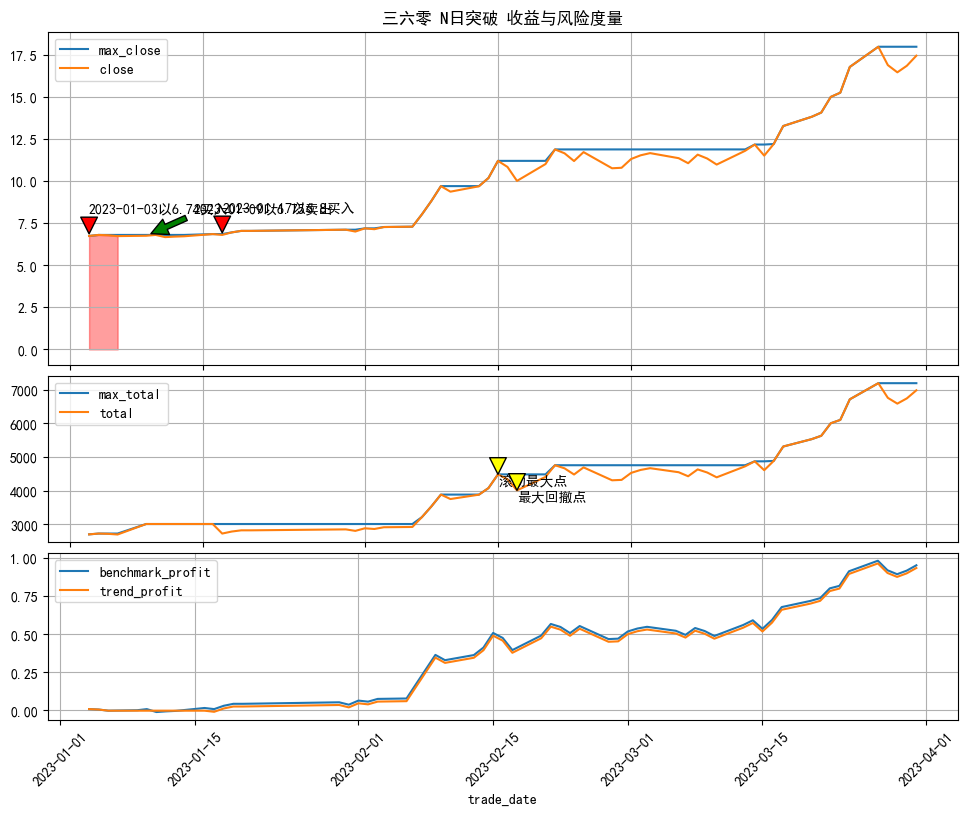

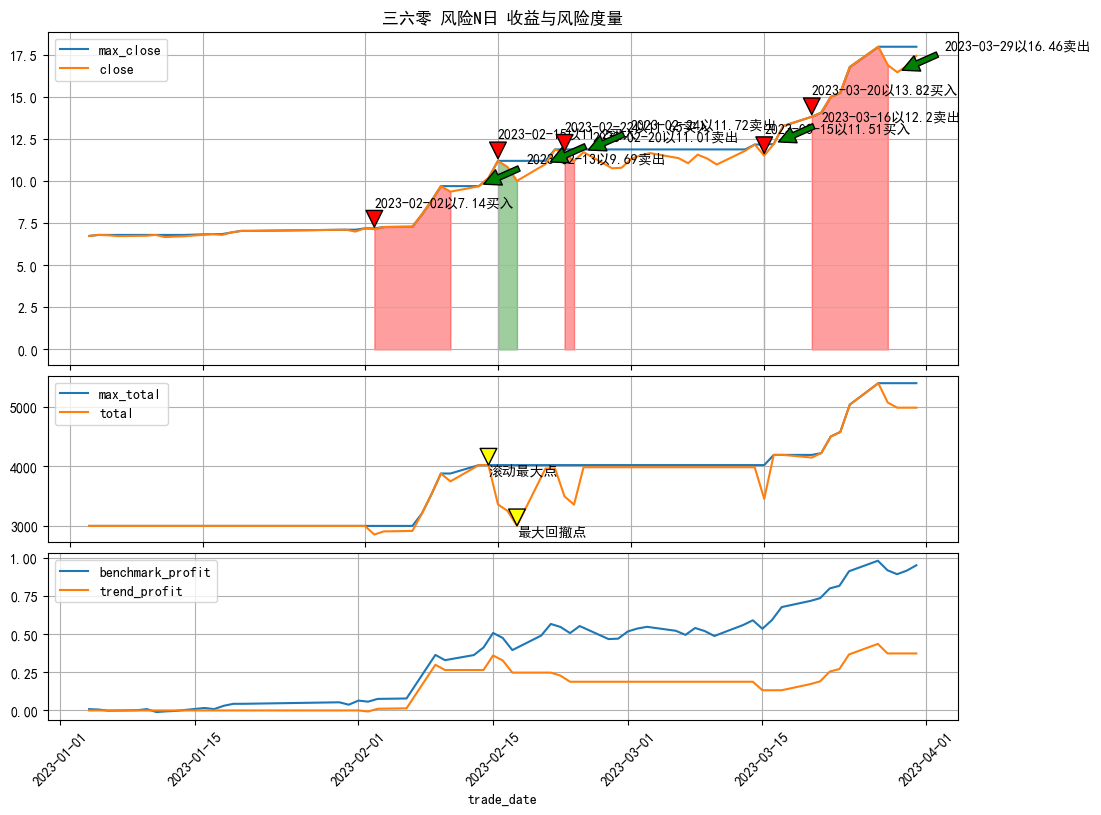

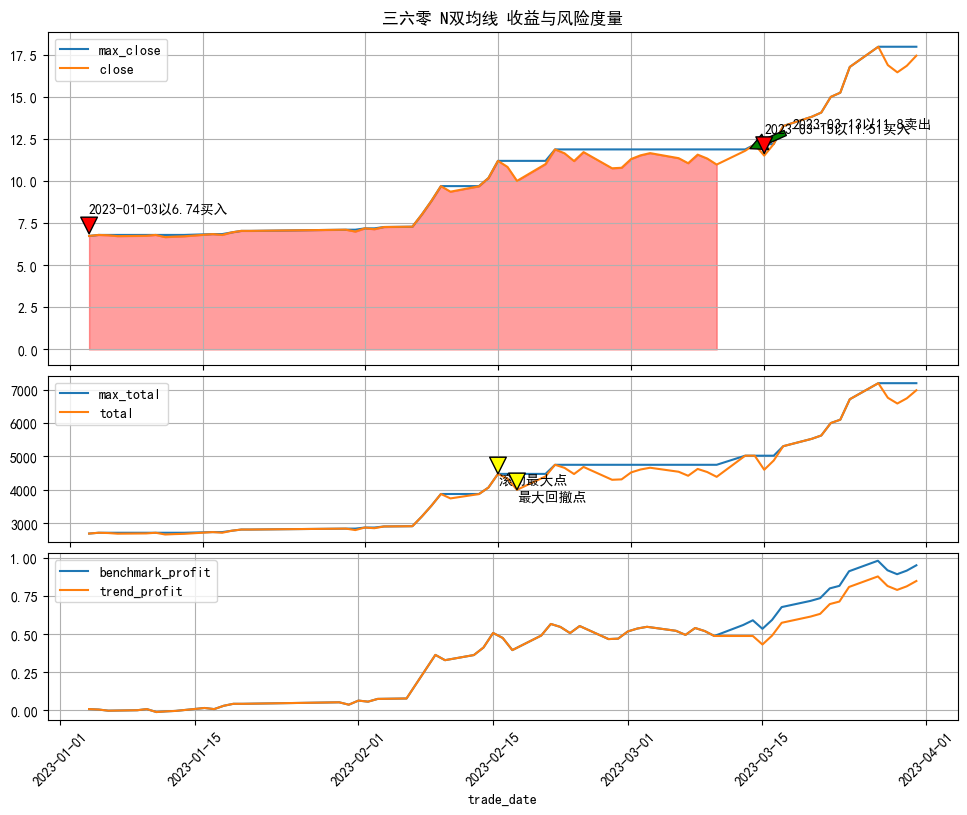

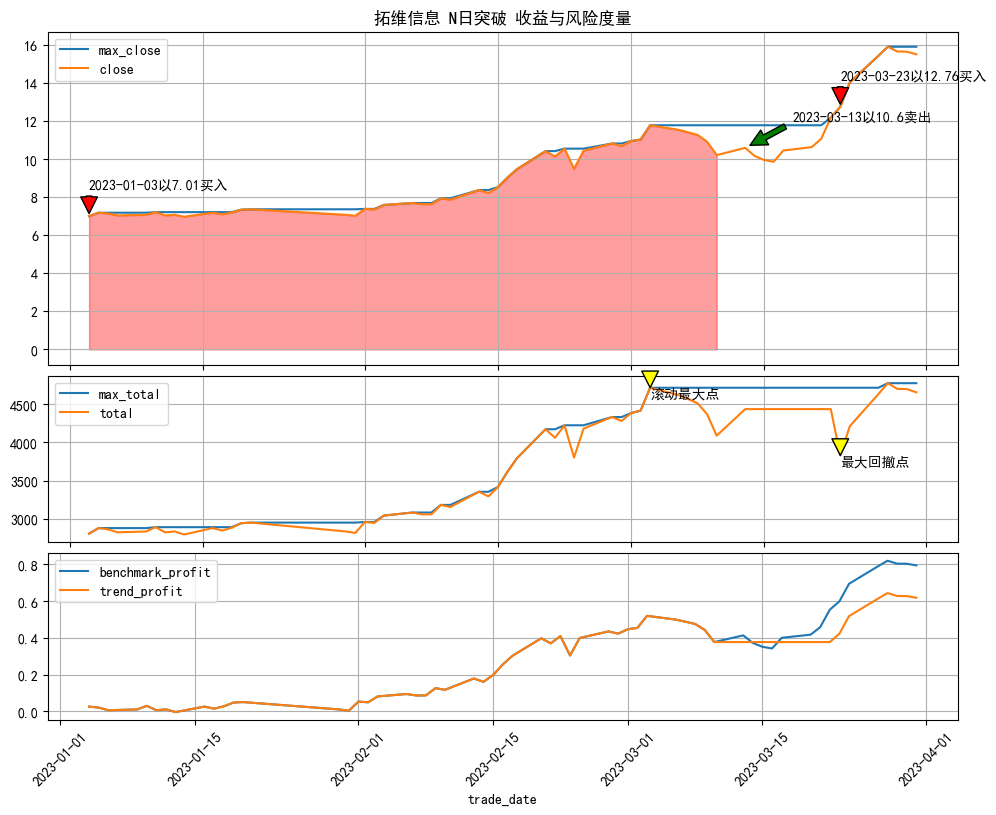

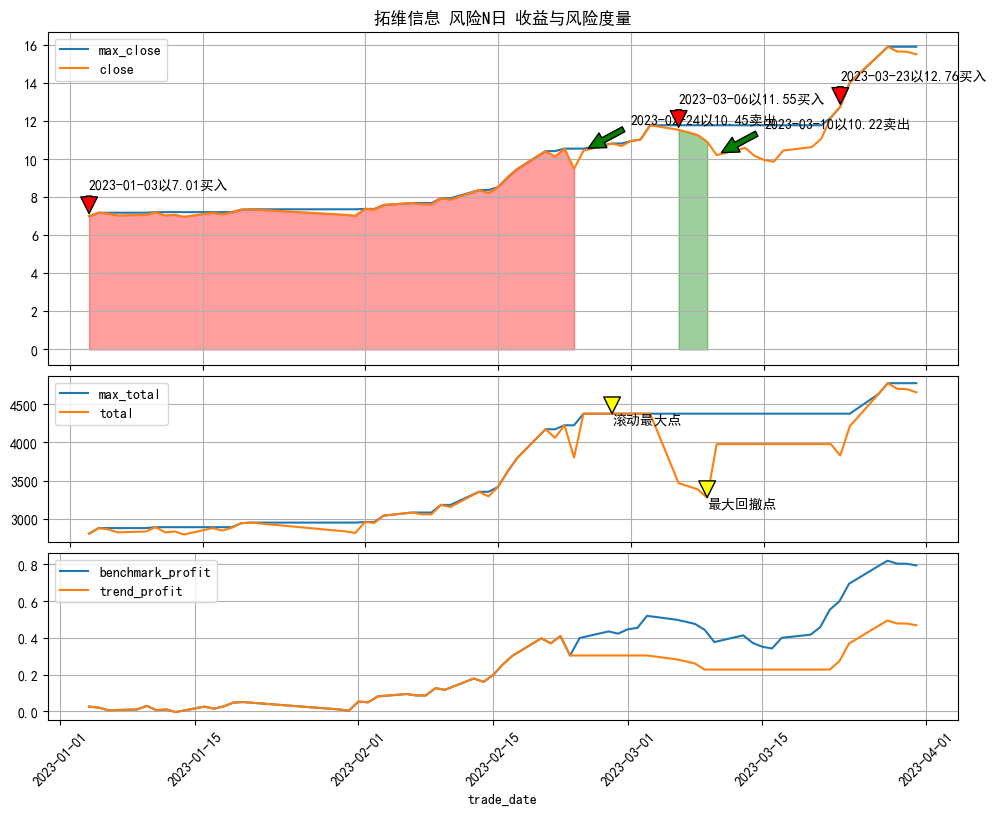

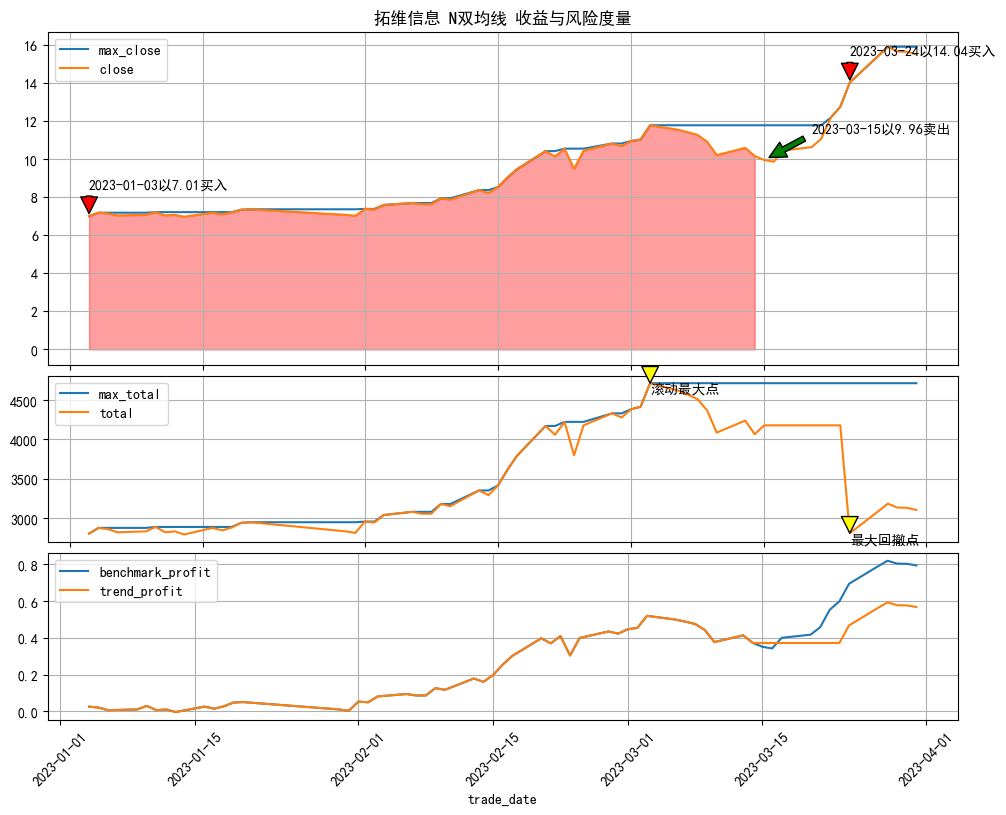

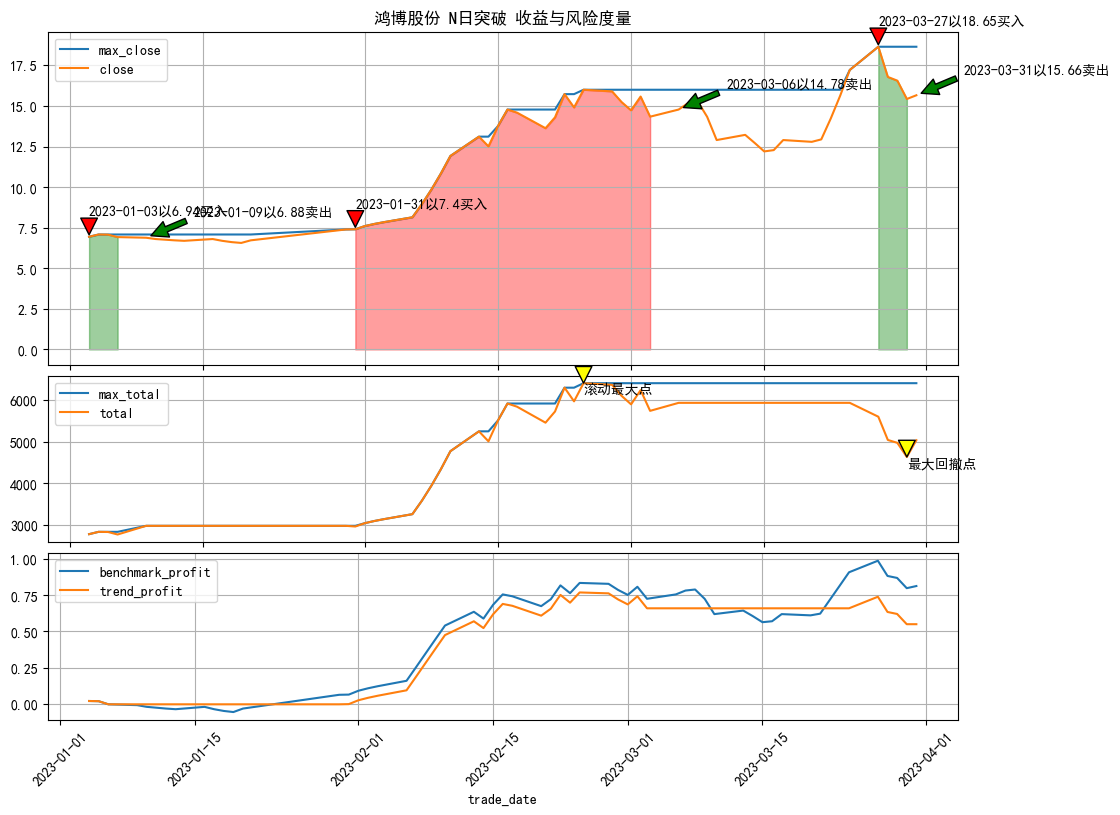

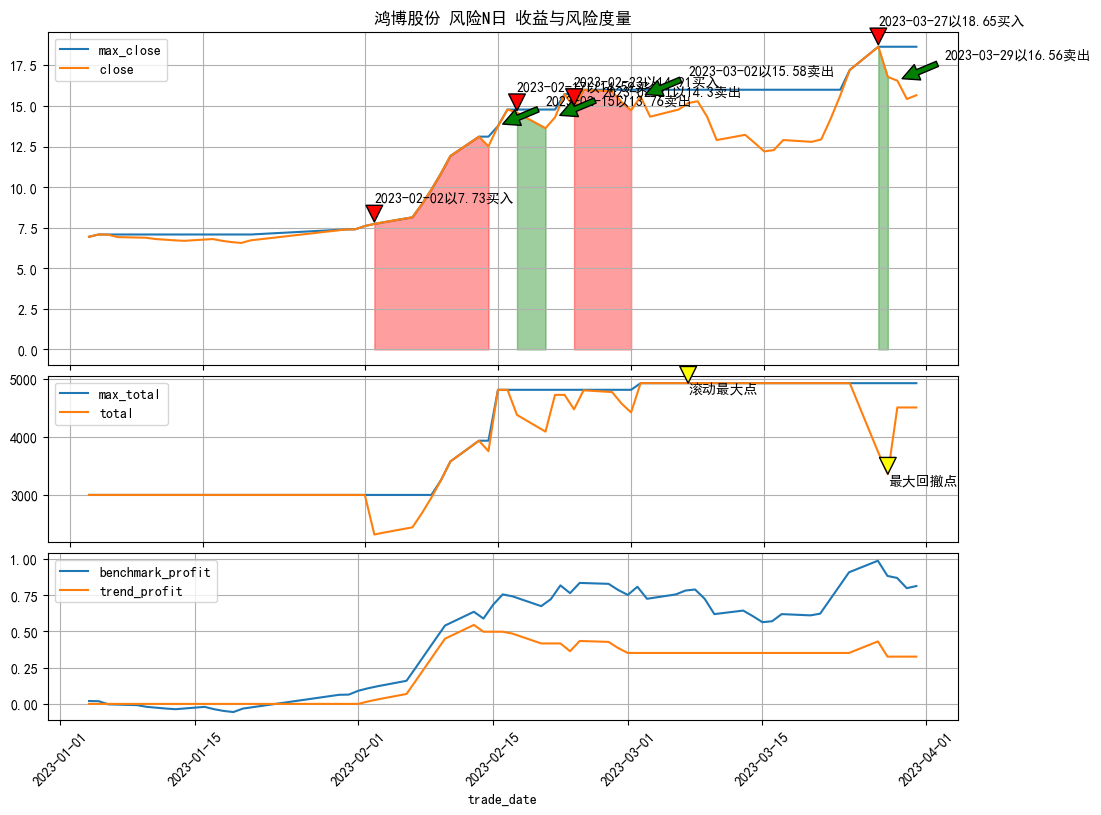

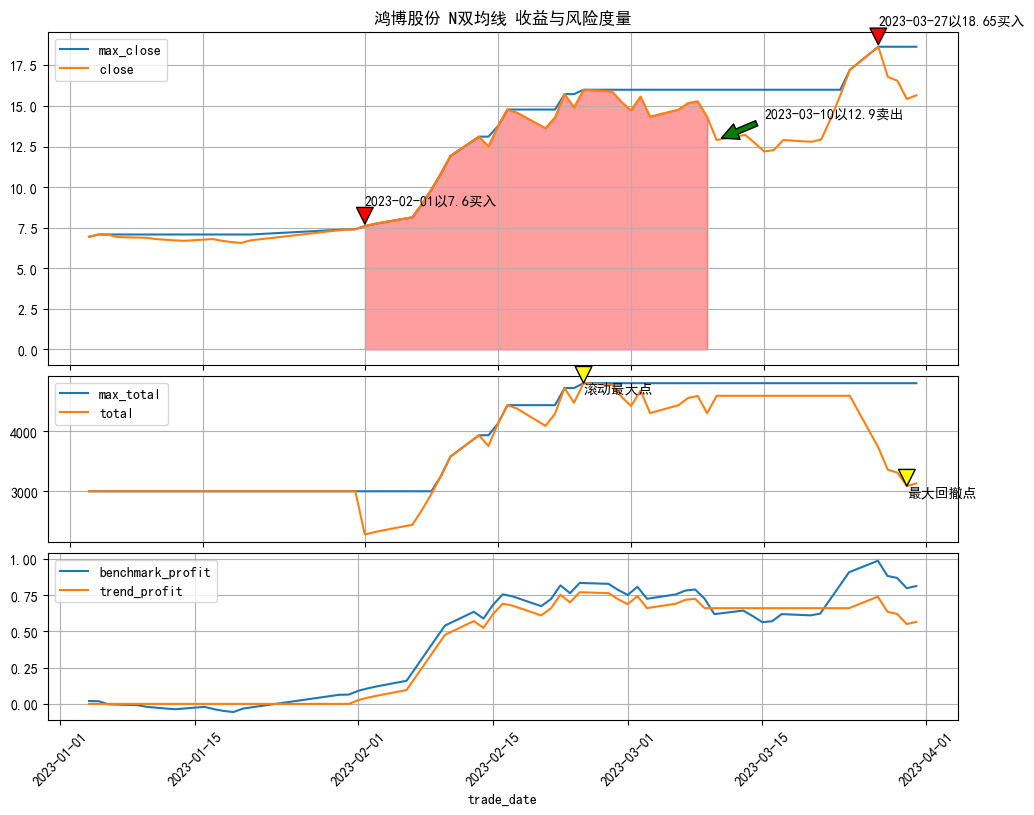

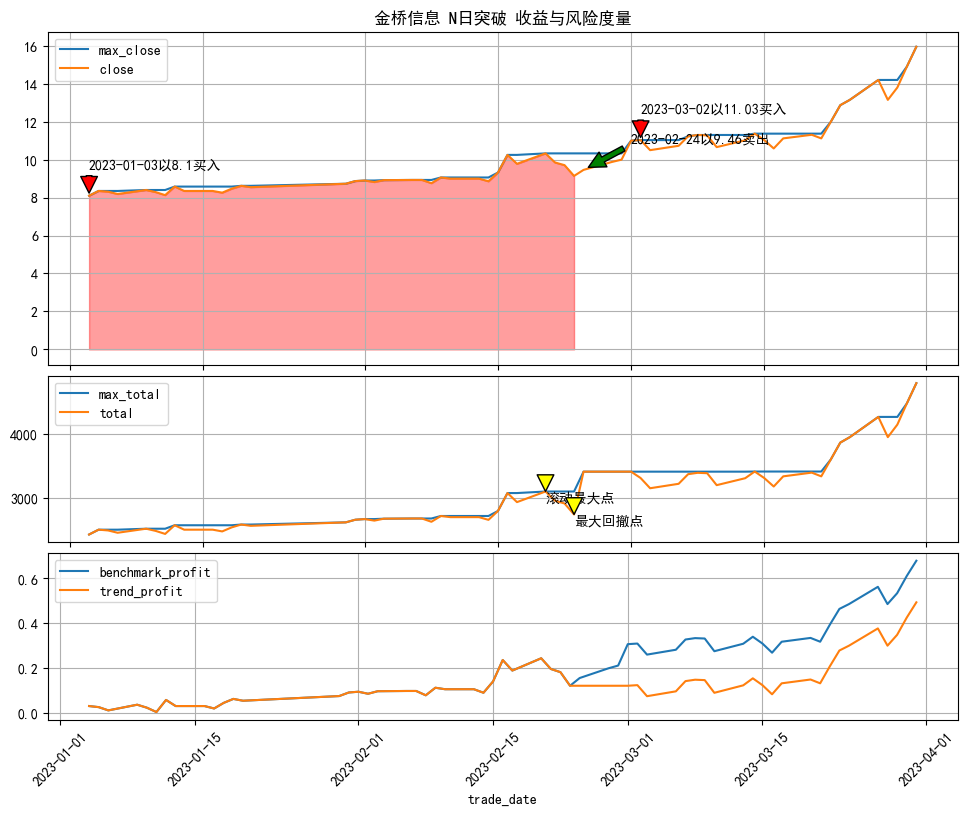

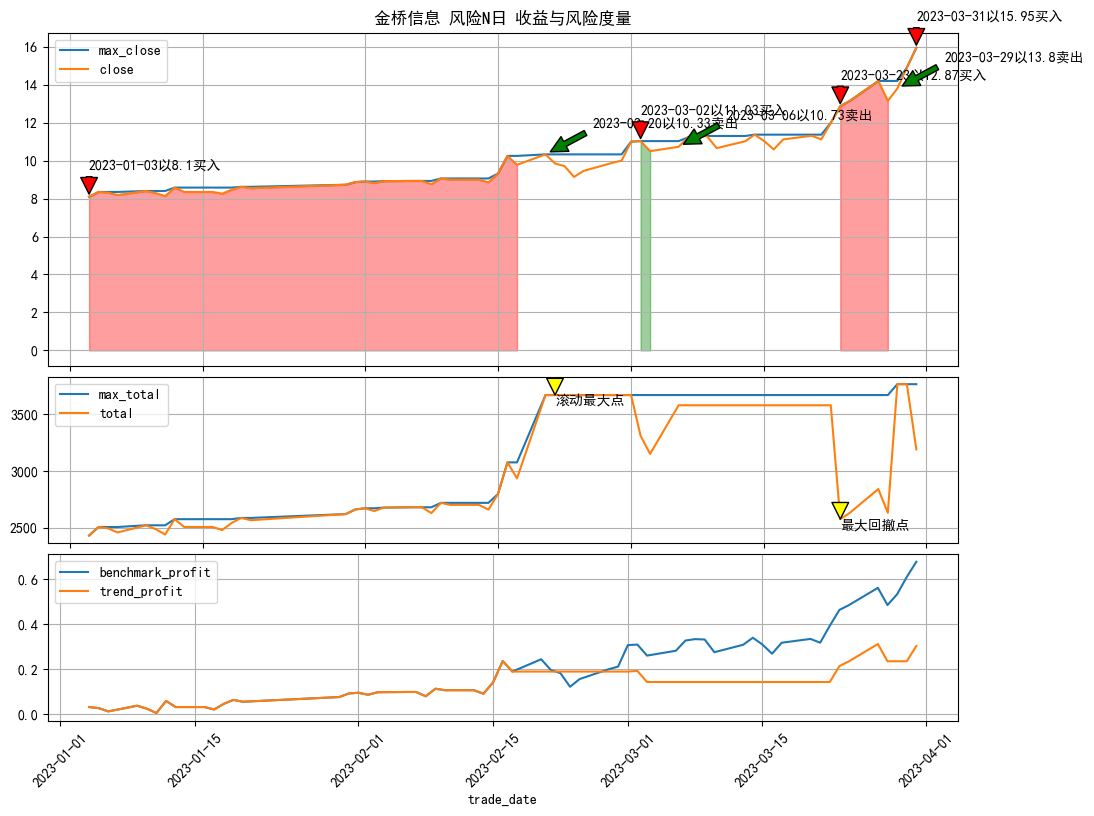

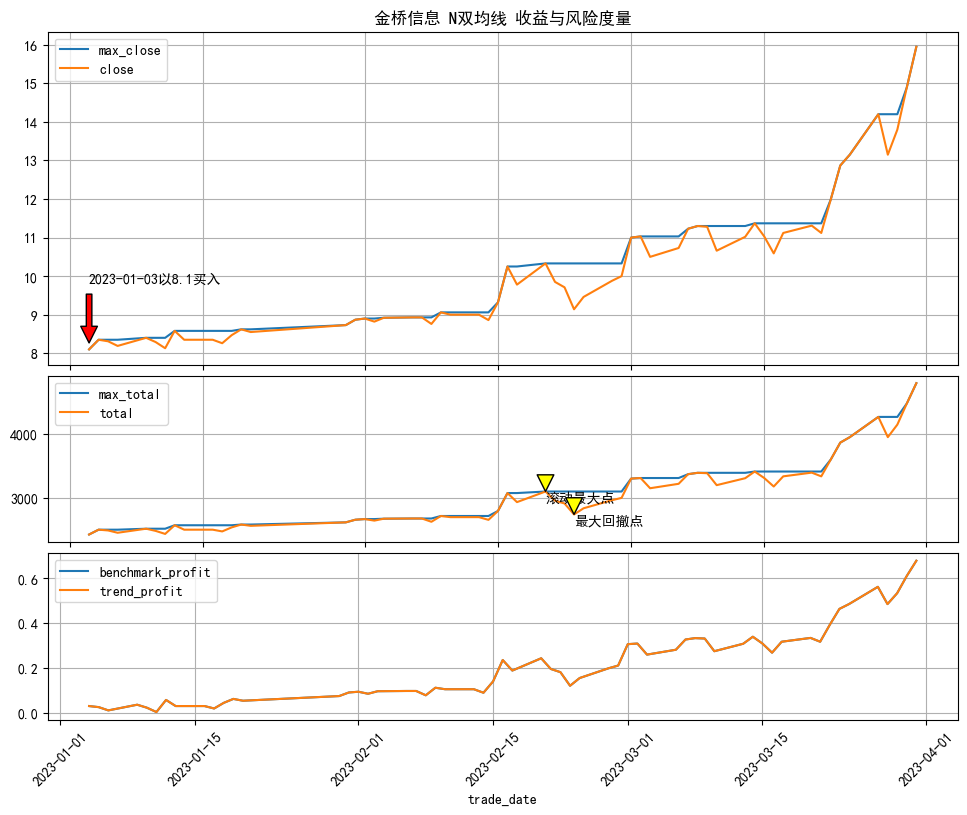

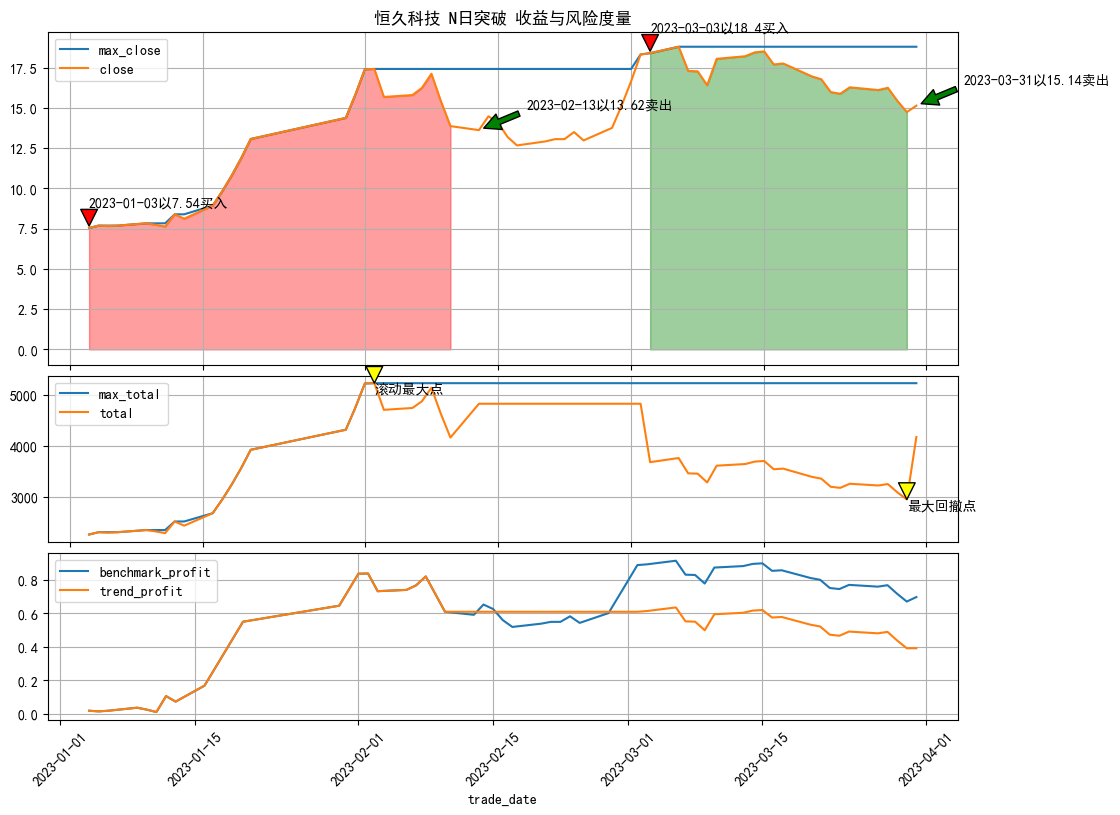

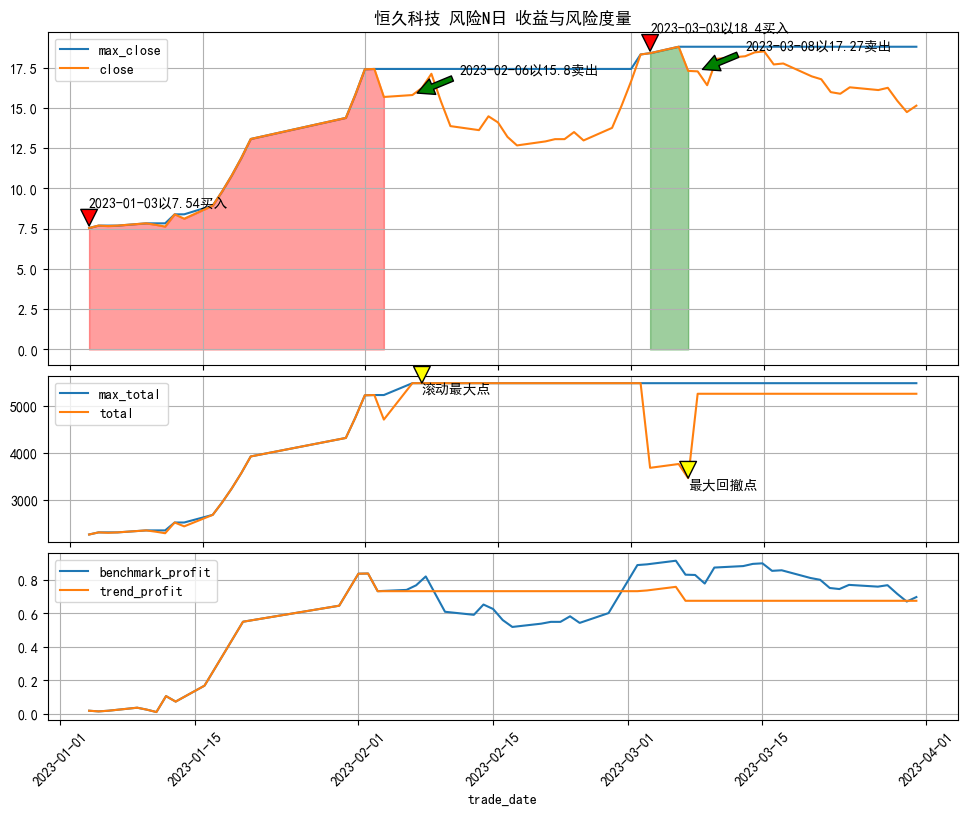

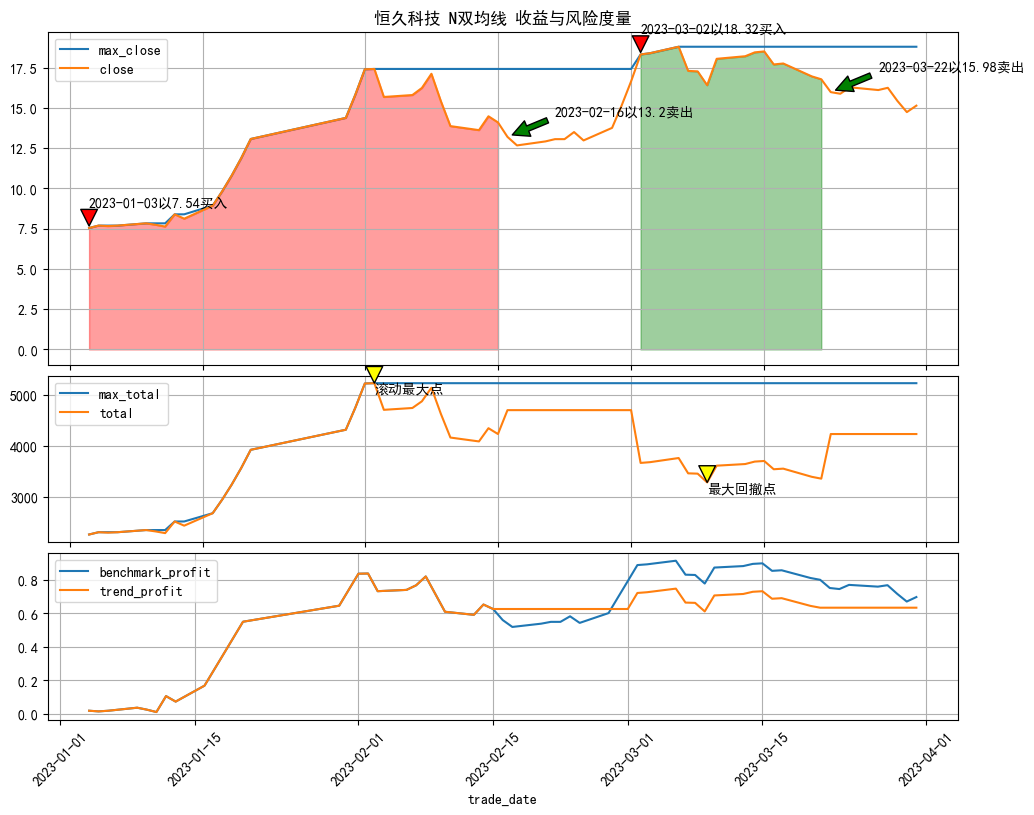

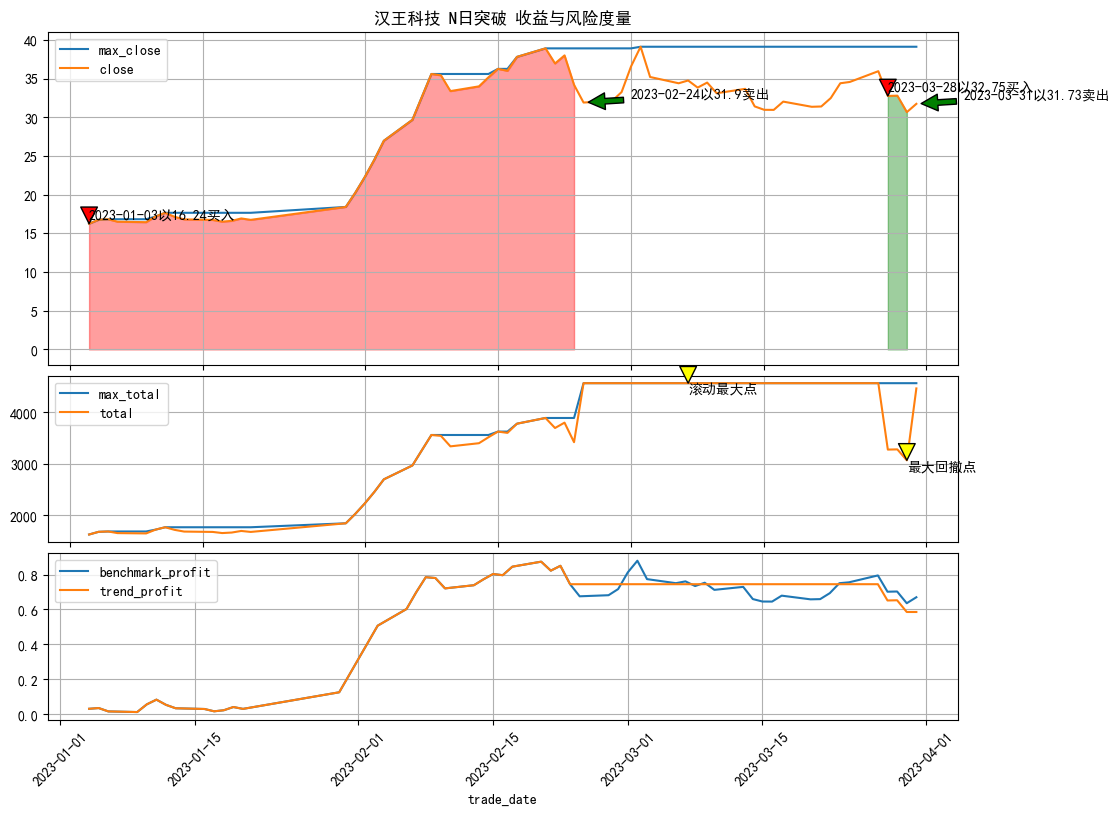

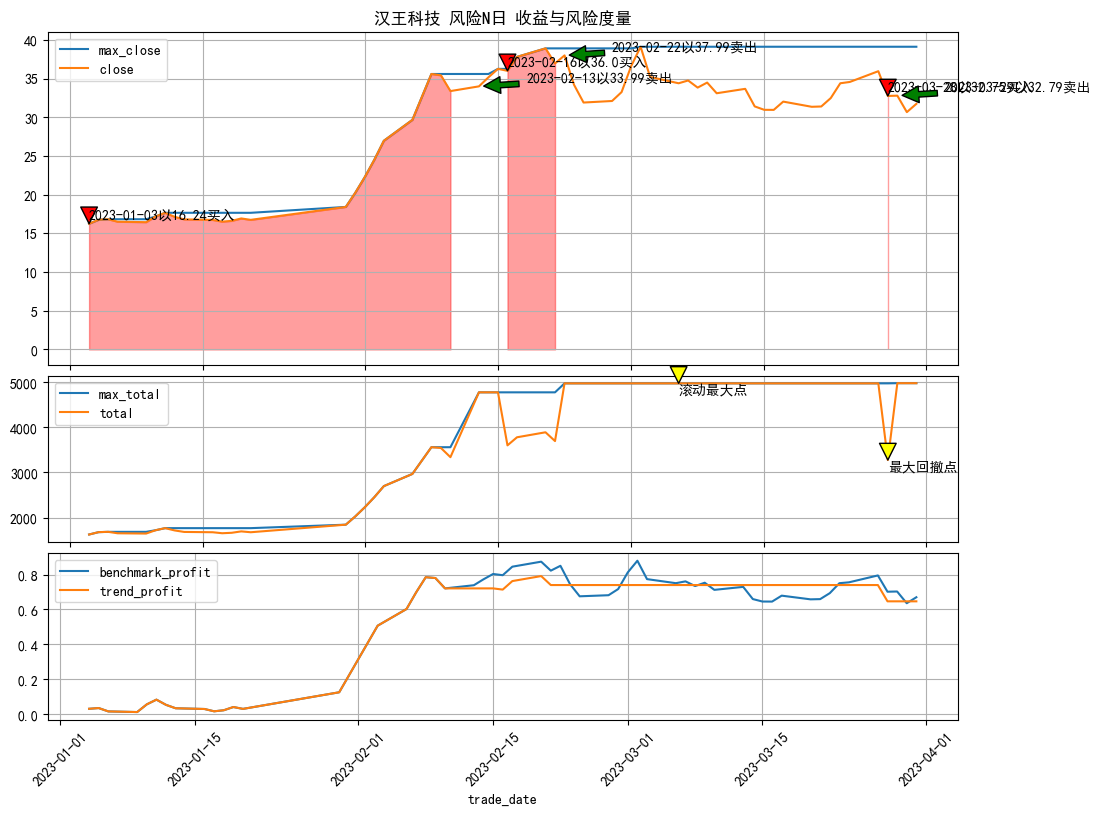

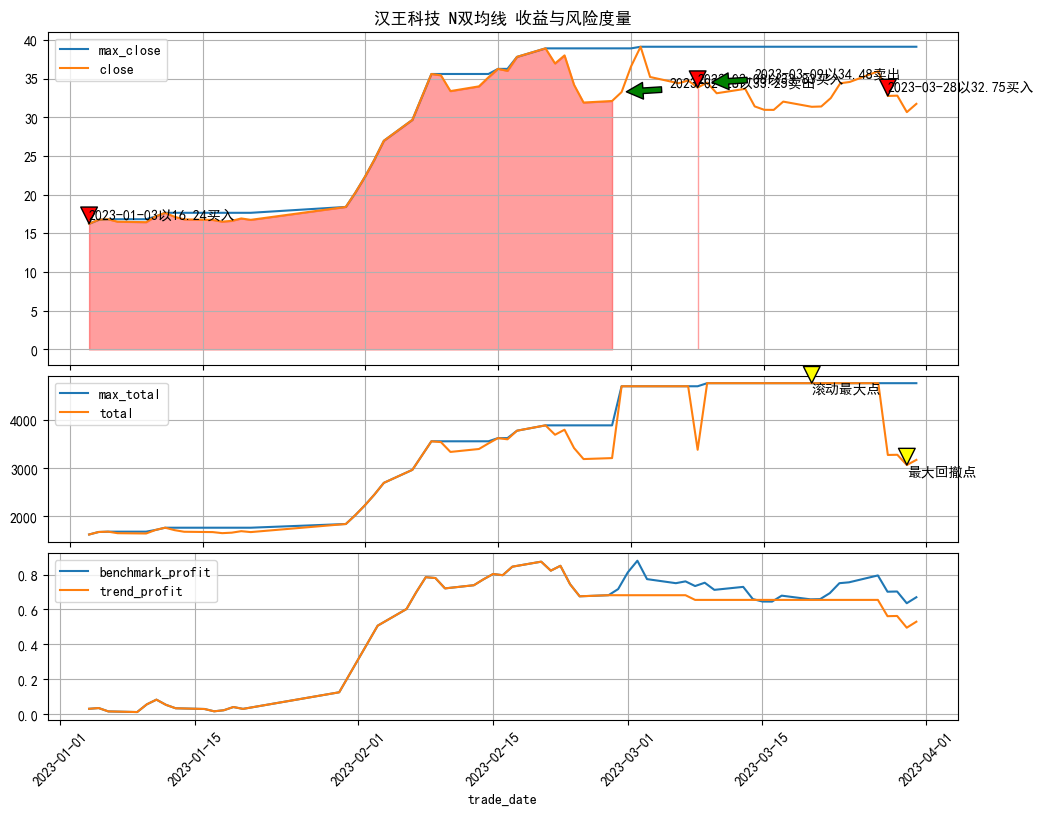

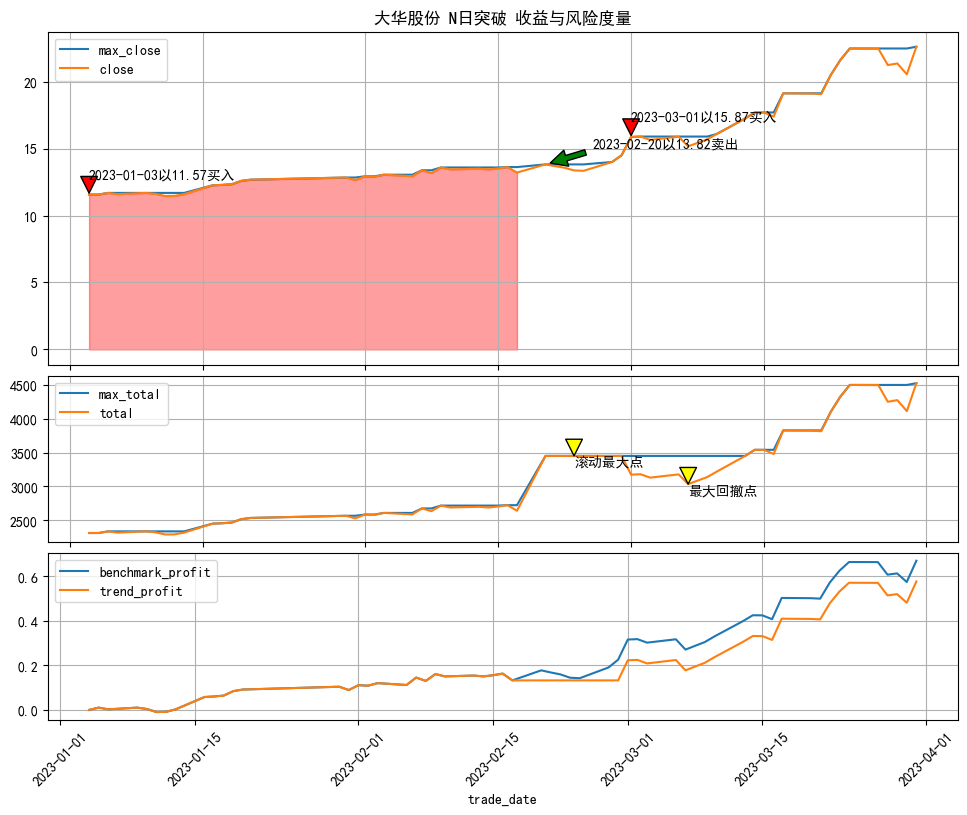

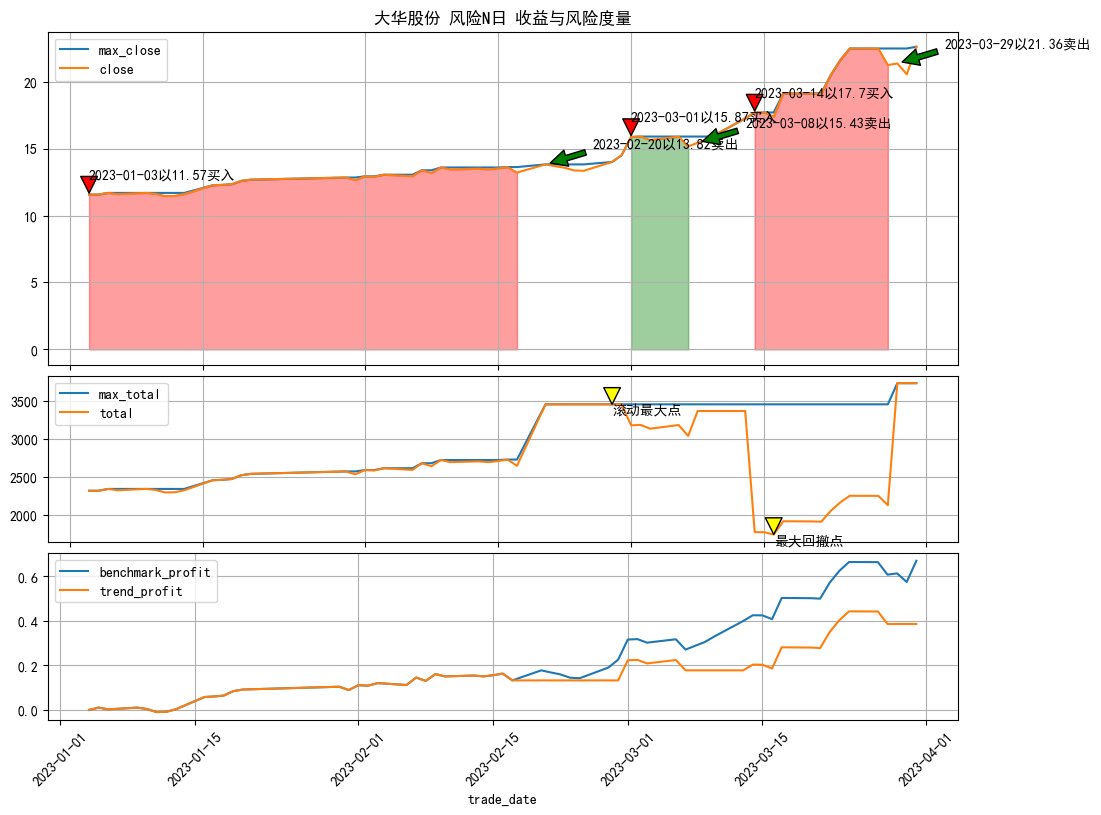

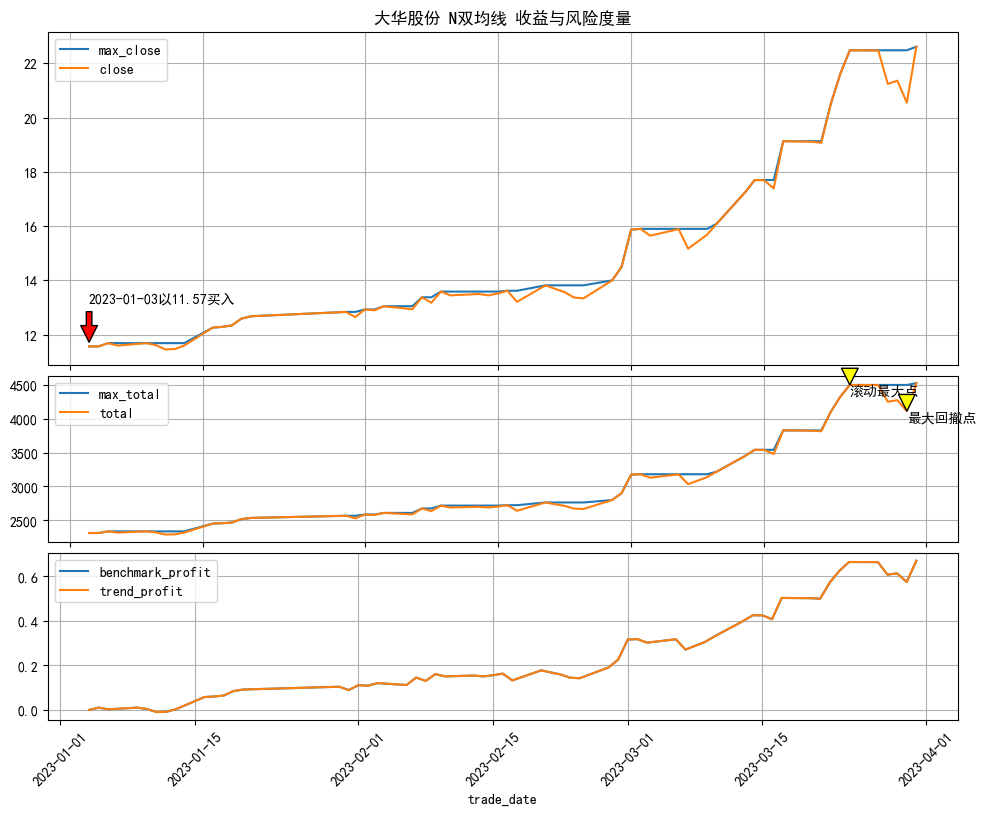

In [17]:
for key,value in good_dict.items():
    print(key)
    print("-"*50)
    ChooseAll(value,key,'20230101',now,3000)